In [3]:
import zipfile
import os

zip_file_path = "/content/drive/MyDrive/RGB-Prepro.zip"  # Update this with the actual path of your uploaded zip file
extracted_folder_path = "/content/"  # Specify the path where you want to extract the contents

# Create the target directory if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print("Extraction completed.")

Extraction completed.


In [4]:
import os

# Set the paths for the images and annotations folders
images_folder = '/content/images'
annotations_folder = '/content/annotations'

# List all image files in the images folder
image_files = [file for file in os.listdir(images_folder) if file.endswith('.png')]

# List all annotation files in the annotations folder
annotation_files = [file for file in os.listdir(annotations_folder) if file.endswith('.xml')]

# Create a set of image filenames without the file extension
image_filenames_without_extension = {os.path.splitext(file)[0] for file in image_files}

# Create a set of annotation filenames without the file extension
annotation_filenames_without_extension = {os.path.splitext(file)[0] for file in annotation_files}

# Find images without corresponding annotations
unlabeled_images = image_filenames_without_extension - annotation_filenames_without_extension

# Delete unlabeled images
for filename in unlabeled_images:
    image_path = os.path.join(images_folder, f"{filename}.png")
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Deleted: {image_path}")

print("Deletion of unlabeled images complete.")


Deleted: /content/images/AOI_3_Paris_img666.png
Deleted: /content/images/AOI_3_Paris_img5.png
Deleted: /content/images/AOI_3_Paris_img462.png
Deleted: /content/images/AOI_3_Paris_img1390.png
Deleted: /content/images/AOI_3_Paris_img1843.png
Deleted: /content/images/AOI_3_Paris_img395.png
Deleted: /content/images/AOI_3_Paris_img1032.png
Deleted: /content/images/AOI_3_Paris_img41.png
Deleted: /content/images/AOI_3_Paris_img991.png
Deleted: /content/images/AOI_3_Paris_img14.png
Deleted: /content/images/AOI_3_Paris_img706.png
Deleted: /content/images/AOI_3_Paris_img540.png
Deleted: /content/images/AOI_3_Paris_img47.png
Deleted: /content/images/AOI_3_Paris_img367.png
Deleted: /content/images/AOI_3_Paris_img89.png
Deleted: /content/images/AOI_3_Paris_img1517.png
Deleted: /content/images/AOI_3_Paris_img8.png
Deleted: /content/images/AOI_3_Paris_img1486.png
Deleted: /content/images/AOI_3_Paris_img1164.png
Deleted: /content/images/AOI_3_Paris_img571.png
Deleted: /content/images/AOI_3_Paris_img18

In [1]:
!pip install torch_snippets

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch_snippets import Report
import os
import time
import xml.etree.ElementTree as ET
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [3]:
def xml_to_dict(xml_path):
    # Decode the .xml file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Initialize a list to store bounding box information
    bounding_boxes = []

    # Iterate through all bounding boxes in the XML
    for bndbox in root.findall("./bndbox"):
        bbox = {
            "filename": xml_path,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": "building",
            "x1": int(bndbox.find("xmin").text),
            "y1": int(bndbox.find("ymin").text),
            "x2": int(bndbox.find("xmax").text),
            "y2": int(bndbox.find("ymax").text)
        }
        bounding_boxes.append(bbox)

    return bounding_boxes

In [4]:
label_dict = {"building": 1}
# Convert label int to human readable str.
reverse_label_dict = {1: "building"}

class BuildingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.root = root
        self.transforms = transforms
        self.files = sorted(os.listdir("images"))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]
        self.label_dict = label_dict

    def __getitem__(self, i):
        # Load image from the hard disc.
        img = PIL.Image.open(os.path.join(self.root,
              "images/" + self.files[i] + ".png")).convert("RGB")

        # Load annotation file from the hard disc and get all bounding boxes
        ann_boxes = xml_to_dict(os.path.join(self.root,
              "annotations/" + self.files[i] + ".xml"))

        # The target is given as a dict with lists for multiple bounding boxes
        target = {
            "boxes": torch.as_tensor([[ann["x1"], ann["y1"], ann["x2"], ann["y2"]] for ann in ann_boxes], dtype=torch.float32),
            "labels": torch.as_tensor([label_dict[ann["label"]] for ann in ann_boxes], dtype=torch.int64),
            "image_id": torch.as_tensor(i)
        }

        # Apply any transforms to the data if required.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.files)

In [5]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [6]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [7]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.9))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [8]:
# Train dataset.
# Set train = True to apply the training image transforms.
train_ds = BuildingDataset("./", get_transform(train = True))
# Validation dataset.
val_ds = BuildingDataset("./", get_transform(train = False))
# Test dataset.
test_ds = BuildingDataset("./", get_transform(train = False))

In [9]:
# Randomly shuffle all the data.
indices = torch.randperm(len(train_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits.
# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.8)])
# Validation dataset: 16% of the entire data, or 20% of 80%.
#val_ds = torch.utils.data.Subset(val_ds,indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds,
          indices[int(len(indices) * 0.8):])

In [10]:
len(indices[:int(len(indices)*0.8)])

506

In [11]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets.
train_dl = torch.utils.data.DataLoader(train_ds,
                                 batch_size = 4,
                                 shuffle = True,
                        collate_fn = collate_fn)
#val_dl = torch.utils.data.DataLoader(val_ds,
#                              batch_size = 16,
#                              shuffle = False,
#                    collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds,
                               batch_size = 4,
                              shuffle = False,
                      collate_fn = collate_fn)

In [12]:
train_loader = train_dl
test_loader=test_dl


In [15]:
# For train dataloader
for batch in train_dl:
    X, y = unbatch(batch, device="cuda")  # Change to "cuda" or "cpu" as needed
    batch_length = len(y)
    print(f"Train Batch Length: {batch_length}")




NameError: ignored

In [13]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
from PIL import Image

# Download the model

In [14]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes = 2,
                               feature_extraction = True):
    """
    Inputs
        num_classes: int
            Number of classes to predict. Must include the
            background which is class 0 by definition!
        feature_extraction: bool
            Flag indicating whether to freeze the pre-trained
            weights. If set to True the pre-trained weights will be
            frozen and not be updated during.
    Returns
        model: FasterRCNN
    """
    # Load the pretrained faster r-cnn model.
    model = fasterrcnn_resnet50_fpn(pretrained = True)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    # Replace the original 91 class top layer with a new layer
    # tailored for num_classes.
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    return model

# train and validation the batch of the data

In [15]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

# train the model function

In [16]:
def train_fasterrcnn(model,
                 optimizer,
                  n_epochs,
              train_loader,
        test_loader = None,
                log = None,
               keys = None,
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation
    Dataloaders over n_epochs.
    Returns a Report on the training and validation losses.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    train_obj=[]
    train_box=[]
    val_obj=[]
    val_box=[]
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier",
                   "loss_box_reg",
                "loss_objectness",
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses= train_batch(batch, model,
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N

        train_obj.append(losses['loss_objectness'].item())
        train_box.append(losses['loss_box_reg'].item())

        log.record(pos = pos, train_obj_loss = losses['loss_objectness'],train_box_loss = losses['loss_box_reg'] )



        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses= validate_batch(batch, model,
                                         optimizer, device)
                # Record the current validation loss.
                pos = epoch + (ix + 1) / N

            val_obj.append(losses['loss_objectness'].item())
            val_box.append(losses['loss_box_reg'].item())

            log.record(pos = pos,val_obj_loss = losses['loss_objectness'],val_box_loss = losses['loss_box_reg'] ,
                    end = "\n")



    log.report_avgs(epoch + 1)
    return log , train_box , train_obj , val_box , val_obj

In [ ]:
# Create the faster rcnn model with 3 classes - dog, cat and
# background.
import time

start = time.time()
model = get_object_detection_model(num_classes = 2,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                        lr = 0.001,
                    momentum = 0.9,
             weight_decay = 0.0005)
# Train the model over 1 epoch.
log , train_box , train_obj , val_box , val_obj= train_fasterrcnn(model = model,
               optimizer = optimizer,
                        n_epochs = 50,
             train_loader = train_dl,
                test_loader = test_dl,
                     device = torch.device("cuda"))

end= time.time()

EPOCH: 1.000  train_obj_loss: 0.153  train_box_loss: 0.542  (95.79s - 4693.86s remaining)
EPOCH: 1.000  val_obj_loss: 0.117  val_box_loss: 0.527  (108.83s - 5332.81s remaining)
EPOCH: 2.000  train_obj_loss: 0.133  train_box_loss: 0.540  (203.54s - 4885.05s remaining)
EPOCH: 2.000  val_obj_loss: 0.153  val_box_loss: 0.529  (216.44s - 5194.45s remaining)
EPOCH: 3.000  train_obj_loss: 0.090  train_box_loss: 0.291  (311.19s - 4875.24s remaining)
EPOCH: 3.000  val_obj_loss: 0.103  val_box_loss: 0.483  (323.97s - 5075.54s remaining)
EPOCH: 4.000  train_obj_loss: 0.088  train_box_loss: 0.484  (418.83s - 4816.57s remaining)
EPOCH: 4.000  val_obj_loss: 0.108  val_box_loss: 0.459  (431.68s - 4964.32s remaining)


In [ ]:
import pandas as pd

# Create a dictionary with the data
data = {
    "epochs": list(range(1, 51)),
    "train_box": train_box,
    "train_obj": train_obj,
    "val_box": val_box,
    "val_obj": val_obj
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Print the DataFrame
df

In [ ]:
print("The time is : " ,end-start)

In [25]:
import torch
from sklearn.metrics import average_precision_score, precision_score, recall_score



@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels, and confidence scores.
    """
    model.to(device)
    model.eval()
    X, y = unbatch(batch, device=device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions, y



def calculate_metrics(predictions, ground_truth):

  true_positives = []
  false_positives = []
  num_ground_truth = 0

  # Loop through each image's ground truth and predictions
  for gt, pred in zip(ground_truth, predictions):
      # Extract boxes and labels
      gt_boxes = gt['boxes'].cpu().numpy()
      gt_labels = gt['labels'].cpu().numpy()
      pred_boxes = pred['boxes'].cpu().numpy()
      pred_scores = pred['scores'].cpu().numpy()
      pred_labels = pred['labels'].cpu().numpy()

      # Sort predictions by score in descending order
      sorted_idx = np.argsort(pred_scores)[::-1]
      pred_boxes = pred_boxes[sorted_idx]
      pred_labels = pred_labels[sorted_idx]

      # Initialize variables for this image
      image_true_positives = np.zeros(len(pred_boxes))
      image_false_positives = np.zeros(len(pred_boxes))
      num_gt = len(gt_boxes)

      # If there are no ground truth objects, mark all detections as false positives
      if num_gt == 0:
          false_positives.extend([1] * len(pred_boxes))
          true_positives.extend([0] * len(pred_boxes))
          num_ground_truth += num_gt
          continue

      # Initialize an array to keep track of used ground truth bounding boxes
      gt_detected = np.zeros(num_gt)

      # Loop through each predicted bounding box
      for i, pred_box in enumerate(pred_boxes):
          # Calculate IoU with all ground truth boxes
          iou = np.zeros(num_gt)
          for j, gt_box in enumerate(gt_boxes):
              x1 = max(pred_box[0], gt_box[0])
              y1 = max(pred_box[1], gt_box[1])
              x2 = min(pred_box[2], gt_box[2])
              y2 = min(pred_box[3], gt_box[3])
              intersection = max(0, x2 - x1) * max(0, y2 - y1)
              union = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1]) + \
                      (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1]) - intersection
              iou[j] = intersection / union

          # Find the maximum IoU and corresponding ground truth box
          max_iou_idx = np.argmax(iou)
          max_iou = iou[max_iou_idx]

          # Check if the maximum IoU is above a certain threshold (e.g., 0.5)
          if max_iou >= 0.5 and not gt_detected[max_iou_idx]:
              image_true_positives[i] = 1
              gt_detected[max_iou_idx] = 1
          else:
              image_false_positives[i] = 1

      # Append true positives and false positives for this image
      true_positives.extend(image_true_positives)
      false_positives.extend(image_false_positives)
      num_ground_truth += num_gt

  # Calculate precision and recall
  precision = np.cumsum(true_positives) / (np.cumsum(true_positives) + np.cumsum(false_positives) + 1e-15)
  recall = np.cumsum(true_positives) / num_ground_truth

  # Calculate average precision (AP) using the trapezoidal rule
  ap = average_precision_score(true_positives, precision)

  return np.mean(precision), np.mean(recall), ap


def predict(model, data_loader, device="cpu"):
    """
    Gets the predictions for a batch of data and calculates metrics.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels, and confidence scores.
        precision: float
            Precision score.
        recall: float
            Recall score.
        mAP_0_5: float
            mAP at IoU threshold of 0.5.
    """
    images = []
    predictions = []
    ground_truth = []
    for i, batch in enumerate(data_loader):
        X, p, y = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
        ground_truth = ground_truth + y

    precision, recall, mAP_0_5 = calculate_metrics(predictions, ground_truth)

    return images, predictions, precision, recall, mAP_0_5


In [26]:
images, predictions, precision, recall, mAP_0_5= predict(model, test_dl, torch.device("cuda"))

In [42]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, y = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions,y
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p ,y= predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p


    return images, predictions,y

In [43]:
def decode_prediction(prediction,
                      score_threshold = 0.8,
                      nms_iou_threshold = 0.2):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores,
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(),
            labels.cpu().numpy(),
            scores.cpu().numpy())

In [44]:
images, predictions ,y= predict(model, val_dl, torch.device("cuda"))

In [47]:
predictions

[{'boxes': tensor([[3.0137e+02, 1.6448e+02, 3.7731e+02, 2.1461e+02],
          [2.1627e+02, 6.0290e+02, 2.8277e+02, 6.4855e+02],
          [2.2400e+02, 3.1201e+02, 3.2175e+02, 3.6511e+02],
          [2.9327e+01, 1.8284e+02, 1.5787e+02, 2.6926e+02],
          [5.4664e+02, 0.0000e+00, 6.0997e+02, 2.8843e+01],
          [2.9580e+02, 5.1166e+02, 3.8359e+02, 5.6592e+02],
          [5.4406e+02, 2.0627e+02, 6.0973e+02, 2.5004e+02],
          [4.2433e+02, 3.2833e+02, 4.8938e+02, 3.7652e+02],
          [5.7004e+02, 1.1801e+02, 6.5000e+02, 2.1869e+02],
          [5.0387e+02, 2.7886e+02, 5.8588e+02, 3.3538e+02],
          [4.7545e+02, 6.2837e+01, 5.5317e+02, 1.1853e+02],
          [1.6369e+01, 5.2003e+02, 7.8360e+01, 5.6094e+02],
          [3.2121e+02, 6.0946e+02, 3.8122e+02, 6.4915e+02],
          [3.7829e+02, 2.0674e+02, 4.5493e+02, 2.6250e+02],
          [1.6717e+00, 3.6957e+01, 1.1702e+02, 1.4788e+02],
          [4.1996e+02, 4.5958e+02, 5.2681e+02, 5.1771e+02],
          [3.0544e+02, 2.8587e+

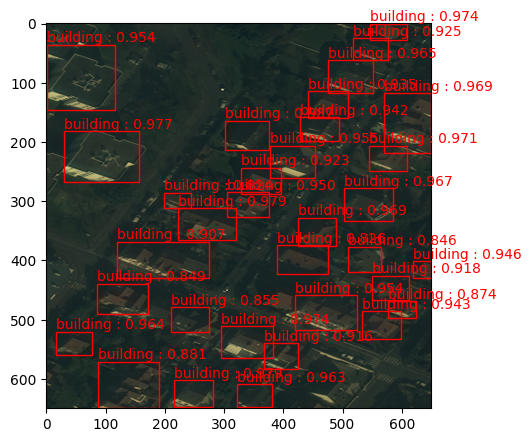

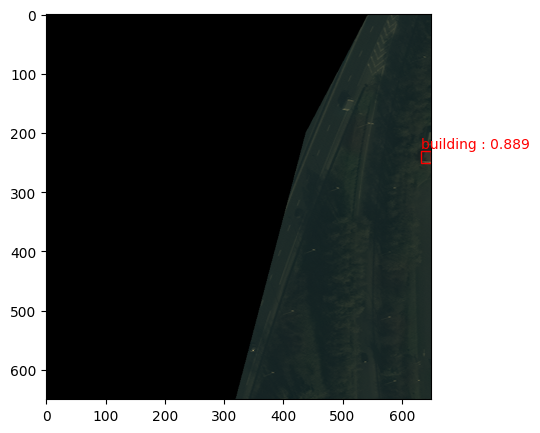

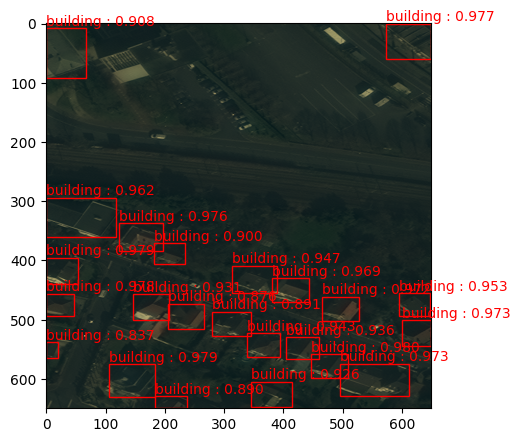

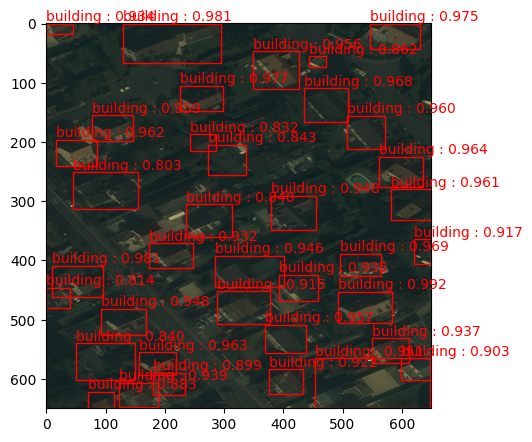

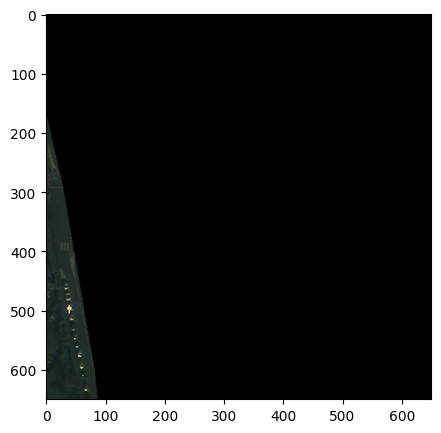

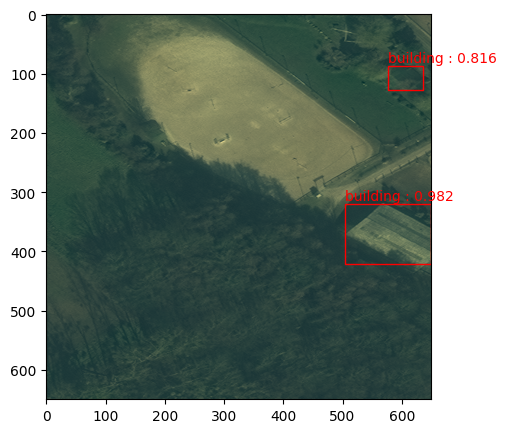

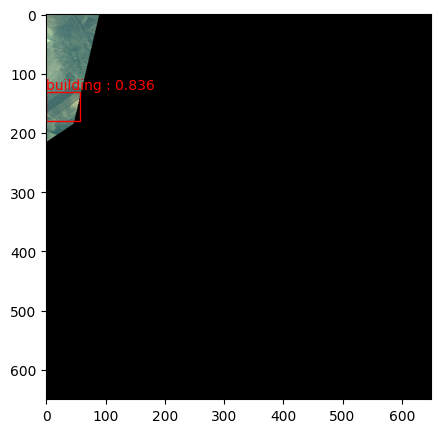

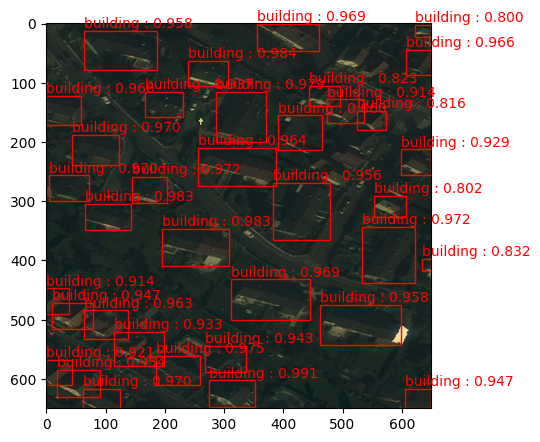

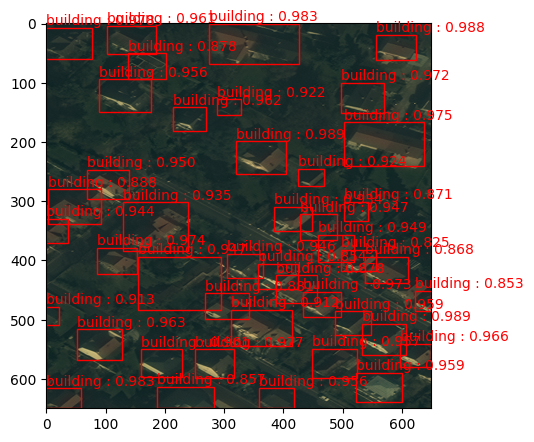

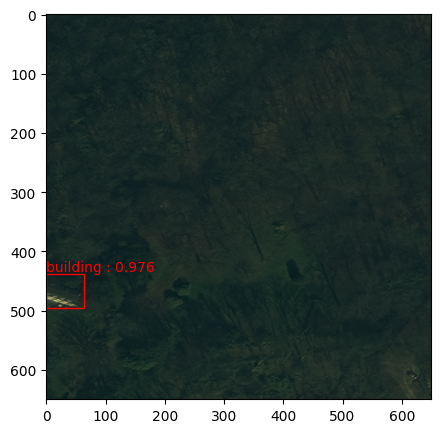

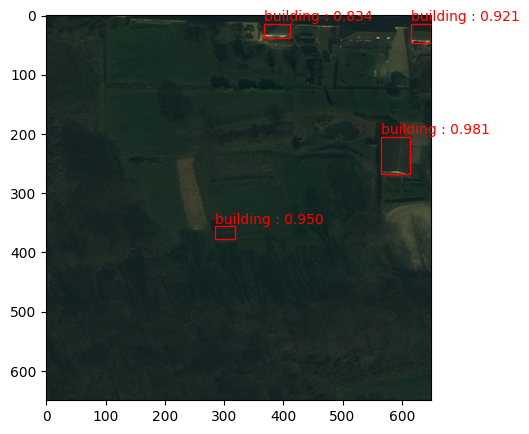

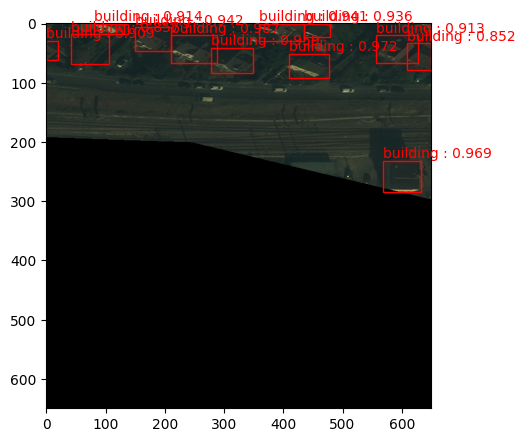

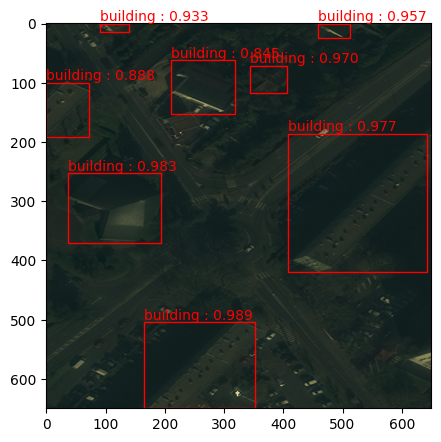

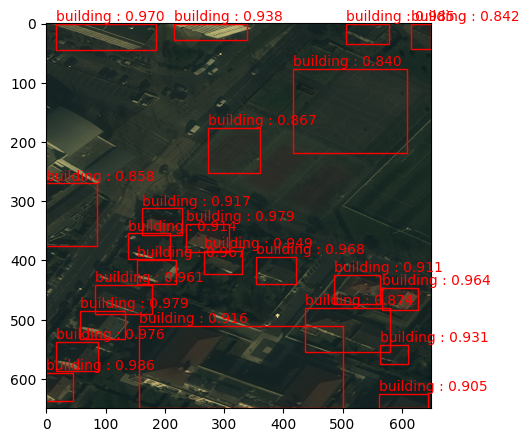

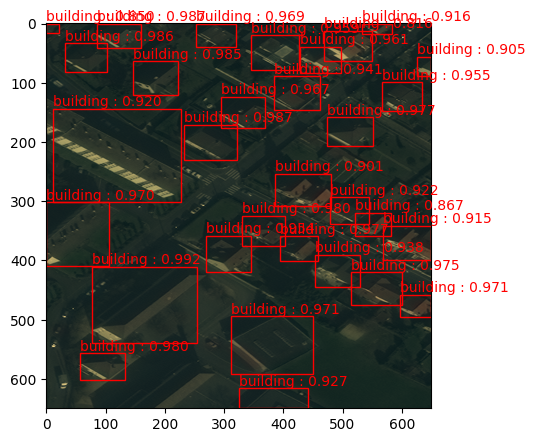

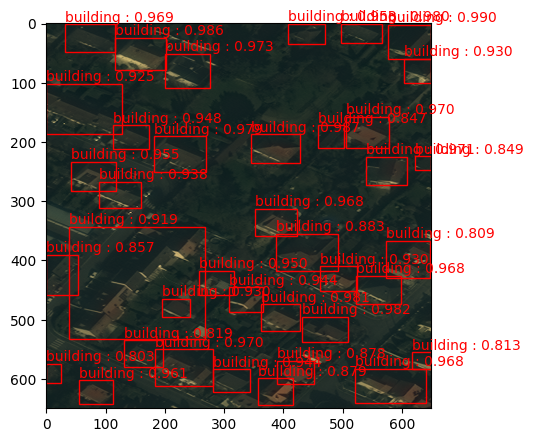

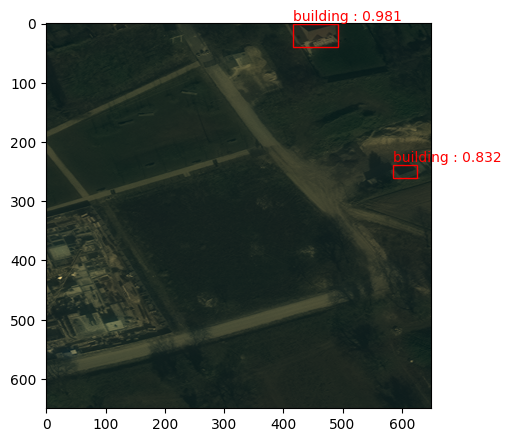

In [54]:
for img_index in range(101):
  boxes, labels, scores = decode_prediction(predictions[img_index])
  fig, ax = plt.subplots(figsize = [5, 5])
  ax.imshow(images[img_index].permute(1, 2, 0).numpy())
  for i, b in enumerate(boxes):
      rect = patches.Rectangle(b[:2].astype(int),
                              (b[2] - b[0]).astype(int),
                              (b[3] - b[1]).astype(int),
                              linewidth = 1,
                              edgecolor = "r",
                              facecolor = "none")
      ax.add_patch(rect)
      ax.text(b[0].astype(int),
              b[1].astype(int) - 5,
              "{} : {:.3f}".format(reverse_label_dict[labels[i]],
              scores[i]), color = "r")
  plt.show()
